# Das Hadeler Problem

\begin{gather}
    T(z) = (e^z - 1) B_1 + z^2 B_2 - B_0 \\
    B_0 = b_0 I, \quad B_1 = (b_{jk}^{(1)}), \quad B_2 = (b_{jk}^{(2)}) \\
    b_{jk}^{(1)} = (n + 1 - \max(j, k)) j k, \quad b_{jk}^{(2)} = n \delta_{jk} + 1 / (j + k)
\end{gather}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from outsource import *

In [2]:
n = 200
b_0 = 100

In [3]:
b_1 = lambda j, k: (n + 1 - max(j, k)) * j * k
b_2 = lambda j, k: n * int(j == k) + 1 / (j + k)

B_0 = b_0 * np.eye(n)
B_1 = np.array([[b_1(j+1, k+1) for k in range(n)] for j in range(n)])
B_2 = np.array([[b_2(j+1, k+1) for k in range(n)] for j in range(n)])

T = lambda z: (np.exp(z) - 1) * B_1 + z ** 2 * B_2 - B_0

In [4]:
N = n

## Referenzwerte

Beim Test 1 haben wir die Referenzwerte explizit in der Hand gehabt.
Jetzt müssen wir diese semi-analytisch bestimmen.
Dazu schließen wir sie mit `integral_method` zunächst in eine hinreichend große Kurve ein.

In [5]:
j = 20
m = 200
R = 11.5
z = -30
tol = 1e-6

quadrature_nodes = [R * (omega(m) ** nu) + z for nu in range(m)]

eigen_values_approx = integral_method(T, N, j, m, R, z, tol)
eigen_values_fake   = integral_method(T, N, j, m, R, z, 0)

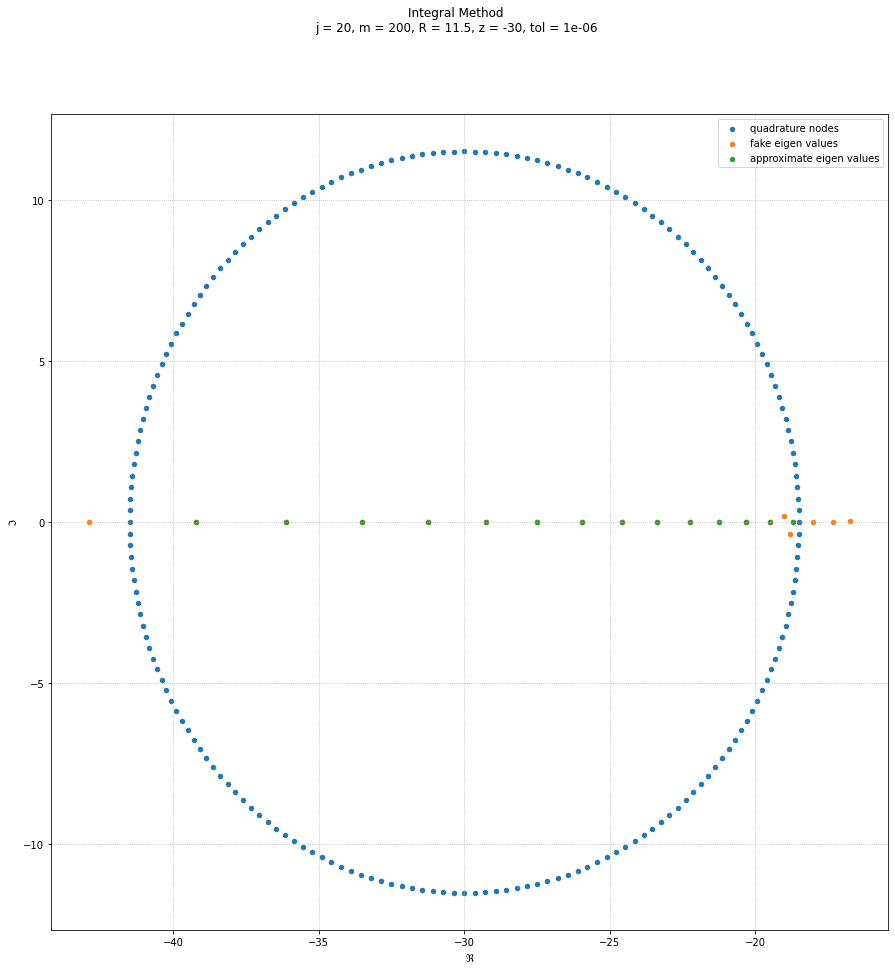

In [6]:
title = 'Integral Method' + '\n' + f'j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('quadrature nodes', 'fake eigen values', 'approximate eigen values')

plot_complex(
    [quadrature_nodes, eigen_values_fake, eigen_values_approx],
    title, legend,
    size_dots = 20
)

Dann wenden wir `integral_method` auf die einzelnen Werte nochmal an, mit kleineren Kurven.

In [7]:
# we expect only 1 eigen_value
j = 1

# we do not need that many quadrature nodes
m = 50

# make radius with smaller radius
# the center point z will be each eigen value
R = 0.5

# leave tolerance as is
tol = 1e-6

eigen_values_ref = [
    integral_method(T, N, j, m, R, eigen_value, tol)[0]
    for eigen_value in eigen_values_approx
]

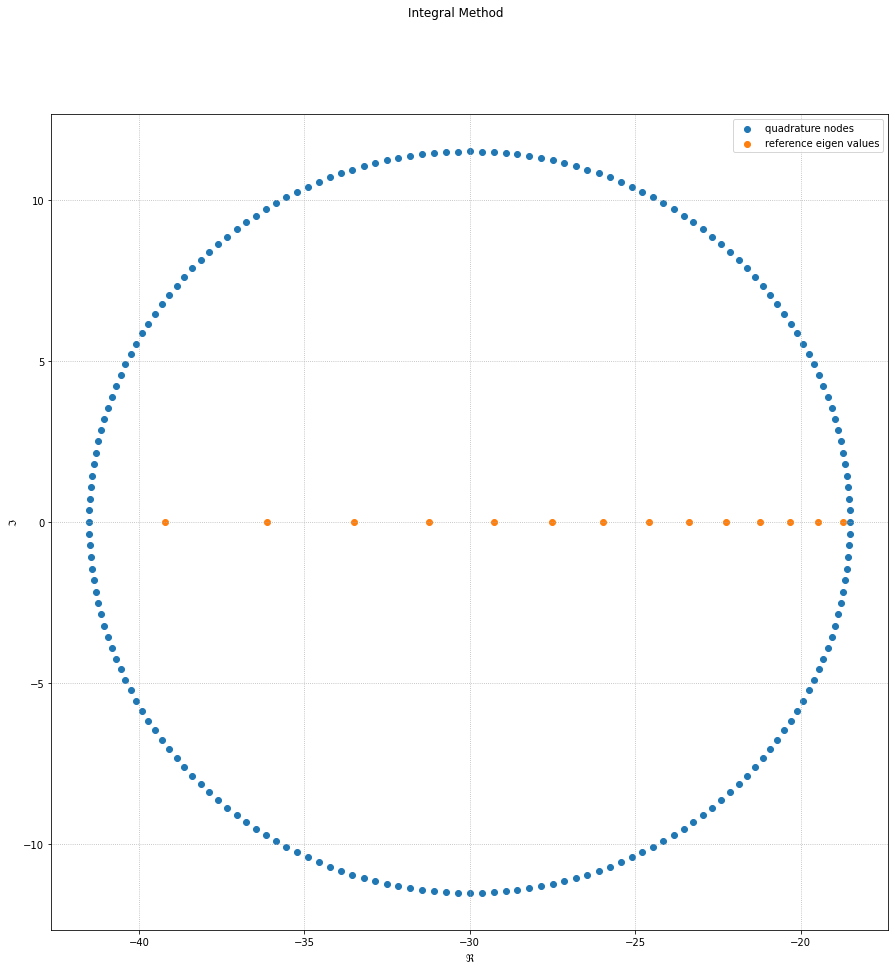

In [8]:
title = 'Integral Method'
legend = ('quadrature nodes', 'reference eigen values')

plot_complex(
    [quadrature_nodes, eigen_values_ref],
    title, legend
)

## Eigenwert überprüfen

Eine Heuristik, um Eigenwerte $\lambda$ zu identifizieren, d.h. ob $A(\lambda)$ singulär ist, besteht darin, die Konditionszahl zu betrachten.
Wenn diese sehr groß wird, dann ist $A(\lambda)$ (fast) singulär.

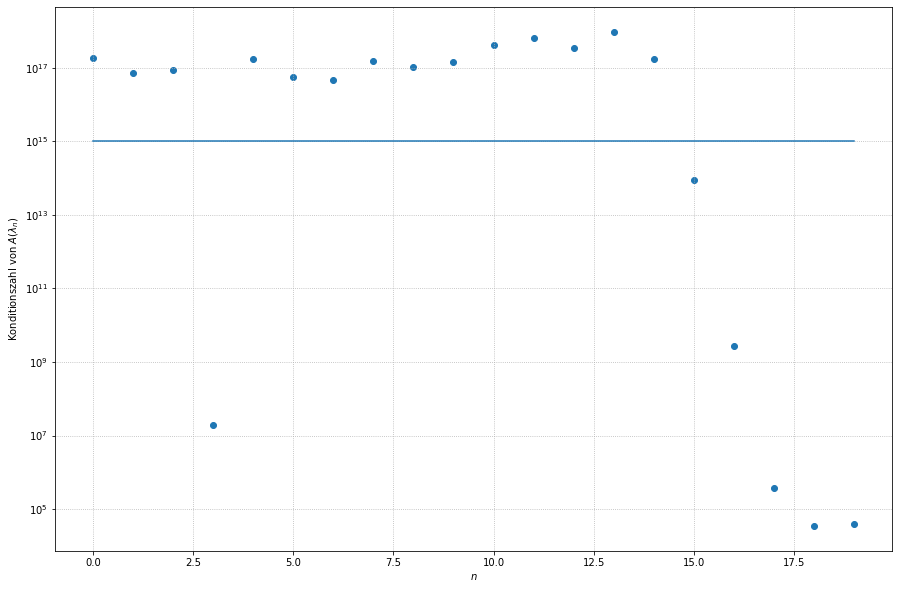

In [9]:
ax = plt.figure(figsize = (15, 10)).gca()

eigen_value_indices = range(len(eigen_values_fake))

ax.scatter(
    eigen_value_indices,
    [np.linalg.cond(T(ref)) for ref in eigen_values_fake]
)

ax.plot(
    eigen_value_indices,
    [1e15] * len(eigen_value_indices)
)

ax.grid(linestyle = ':')
ax.set_yscale('log')

ax.set_xlabel('$n$')
ax.set_ylabel('Konditionszahl von $A(\lambda_n)$')

plt.show()

Wir bekommen also scheinbar tatsächlich $14$ "echte" Eigenwerte (über der Abtrennung).

## Konvergenzplots

In [10]:
j = 15
m_array = [5, 10, 15, 20, 50, 100]
R_array = [9.5, 10.5, 11.5]
z = -30
tol = 1e-6

error_arrays = [
    [
        max([
            min([
                np.abs(eigen_value_approx - eigen_value_ref)
                for eigen_value_ref in eigen_values_ref
            ])
            for eigen_value_approx in integral_method(T, N, j, m, R, z, tol)
        ])
        for m in m_array
    ]
    for R in R_array
]

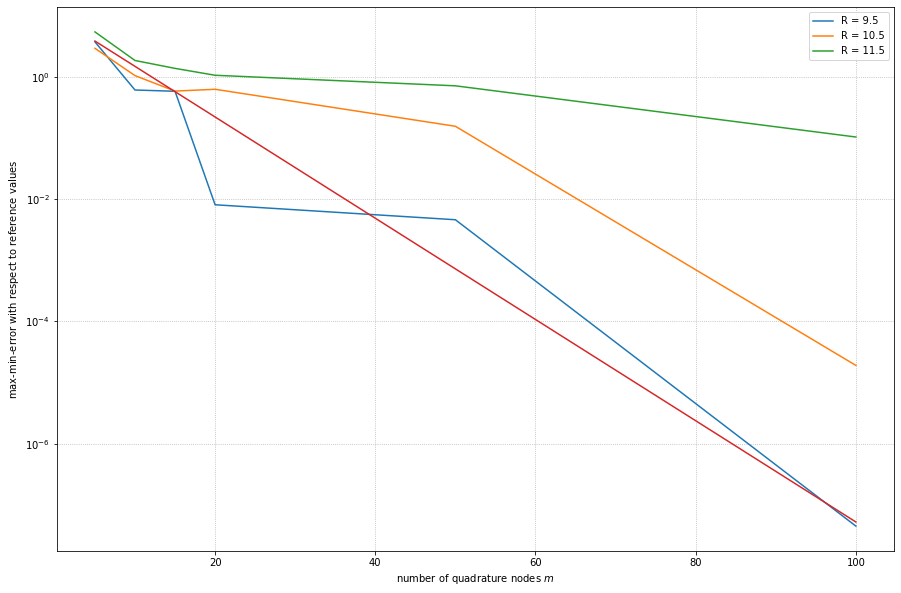

In [11]:
fig = plt.figure(figsize = (15, 10))

for error_array, R in zip(error_arrays, R_array):
    plt.semilogy(m_array, error_array, label = f'R = {R}')

plt.semilogy(m_array,[10*1.21**(-m) for m in m_array])
plt.xlabel('number of quadrature nodes $m$')
plt.ylabel('$\max$-$\min$-error with respect to reference values')

plt.legend()
plt.grid(linestyle = ':')

fig.show()